# Sistema de Recomendación de Películas

Este notebook crea un sistema de recomendación que sugiere películas del Top 250 de IMDB basado en:
- Ratings personales en Letterboxd
- Año de la película
- Géneros
- Actores involucrados
- Directores

## 1. Configuración Inicial
Primero, instalamos e importamos las librerías necesarias.

In [ ]:
# Instalación de paquetes (ejecutar solo una vez)
%pip install imdbpy scikit-learn pandas numpy matplotlib seaborn tqdm

In [1]:
# Importaciones
import pandas as pd
import numpy as np
from imdb import IMDb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
ia = IMDb()

## 2. Carga de Datos

Cargamos tus ratings de Letterboxd y el Top 250 de IMDB.

**Nota**: Se asume que se tienen estos archivos CSV.

In [2]:
def cargar_datos():
    """Carga y prepara los datasets"""
    # Cargar tus ratings de Letterboxd (ajusta los nombres de columnas)
    letterboxd = pd.read_csv('letterboxd_ratings.csv')
    letterboxd = letterboxd.rename(columns={
        'Name': 'title',
        'Year': 'year',
        'Rating': 'rating'
    })

    # Cargar Top 250 de IMDB (puedes generarlo con imdbpy si no tienes el CSV)
    imdb_top = pd.read_csv('imdb_top250.csv')
    imdb_top = imdb_top.rename(columns={
        'name': 'title',
        'year': 'year',
        'rating': 'imdb_rating'
    })

    return letterboxd, imdb_top

In [3]:
letterboxd_ratings, imdb_top = cargar_datos()

## 3. Enriquecimiento de Datos

Vamos a obtener información adicional de IMDB para las películas calificadas.

In [4]:
def serializar(df):
  df = df[['title', 'year', 'imdb_rating', 'genre', 'directors', 'casts', 'run_time']]
  df['genre'] = df['genre'].apply(lambda x: [item.strip() for item in x.split(',')])
  df['directors'] = df['directors'].apply(lambda x: [item.strip() for item in x.split(',')])
  df['casts'] = df['casts'].apply(lambda x: [item.strip() for item in x.split(',')])

  # Convertir tiempo de ejecución a minutos
  def convert_runtime(runtime):
    try:
        parts = runtime.split("h ")
        hours = int(parts[0]) * 60 if parts[0].isdigit() else 0
        minutes = int(parts[1].replace("m", "")) if len(parts) > 1 and parts[1].replace("m", "").isdigit() else 0
        return int(hours + minutes)
    except:
        return None

  df["run_time"] = df["run_time"].apply(convert_runtime)

  df.rename(columns={
    "genre": "genres",
    "casts": "actors",
    "run_time": "runtime"
  }, inplace=True)

  return df
  

In [5]:
df_top_global = None

In [6]:
def obtener_info_local(title, year, df_top):
    """Busca los datos en el CSV local"""
    filtered_df = df_top[df_top['title'] == title]
    if not filtered_df.empty:
        movie = filtered_df.iloc[0]
        return {
            'title': movie['title'],
            'year': movie.get('year', year),
            'imdb_rating': movie.get('imdb_rating', np.nan),
            'genres': movie.get('genres', []),
            'directors': movie.get('directors', []),
            'actors': movie.get('actors', [])[:10],
            'runtime': movie.get('runtime', 0)
        }
    return None

In [7]:
def obtener_info_imdb(title, year):
    """Busca los datos usando la API de IMDb"""
    try:
        resultados = ia.search_movie(f"{title} {year}")
        if not resultados:
            return None

        pelicula = ia.get_movie(resultados[0].movieID)
        
        return {
            'title': pelicula.get('title', title),
            'year': pelicula.get('year', year),
            'imdb_rating': pelicula.get('rating', np.nan),
            'genres': pelicula.get('genres', []),
            'directors': [d['name'] for d in pelicula.get('directors', [])],
            'actors': [a['name'] for a in pelicula.get('actors', [])][:10],
            'runtime': pelicula.get('runtime', [0])[0] if pelicula.get('runtime') else 0
        }
    except Exception:
        return None

In [8]:
def enriquecer_fila(fila):
    """Enriquece una fila con datos de IMDb, primero local, luego API"""
    title = str(fila['title'])
    year = fila['year']
    
    # Buscar primero en el CSV local
    info = obtener_info_local(title, year, df_top_global)
    
    # Si no está, buscar con la API
    if not info:
        info = obtener_info_imdb(title, year)
    
    if info:
        info['user_rating'] = fila['rating']
    return info

In [9]:
def enriquecer_datos(df, df_top, max_workers=20):
    """Añade datos de IMDB a un DataFrame usando concurrencia"""
    global df_top_global
    df_top_global = df_top  # guardar el dataframe para uso dentro de los threads

    datos_enriquecidos = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futuros = {executor.submit(enriquecer_fila, fila): fila for _, fila in df.iterrows()}
        for futuro in tqdm(as_completed(futuros), total=len(futuros)):
            resultado = futuro.result()
            if resultado:
                datos_enriquecidos.append(resultado)
                
    df_top_global = None  # limpiar después
    return pd.DataFrame(datos_enriquecidos)

In [10]:
# Enriquecer datos
imdb_enriched = serializar(imdb_top)

print("\n Dependiendo de la red, esto puede tardar más o menos")
print("\nEnriqueciendo los ratings de Letterboxd...")
letterboxd_enriched = enriquecer_datos(letterboxd_ratings, imdb_enriched)

# Mostrar resultados
print(f"\nPelículas enriquecidas: {len(letterboxd_enriched)}/{len(letterboxd_ratings)}")
display(letterboxd_enriched.head(2))
display(imdb_enriched.head(2))


 Dependiendo de la red, esto puede tardar más o menos

Enriqueciendo los ratings de Letterboxd...


100%|██████████| 184/184 [00:54<00:00,  3.35it/s]


Películas enriquecidas: 184/184


,title,year,imdb_rating,genres,directors,actors,runtime,user_rating
0,Pulp Fiction,1994,8.9,"[Crime, Drama]",[Quentin Tarantino],"[John Travolta, Uma Thurman, Samuel L. Jackson...",154,3.5
1,Schindler's List,1993,9.0,"[Biography, Drama, History]",[Steven Spielberg],"[Liam Neeson, Ralph Fiennes, Ben Kingsley, Car...",195,5.0


,title,year,imdb_rating,genres,directors,actors,runtime
0,The Shawshank Redemption,1994,9.3,[Drama],[Frank Darabont],"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",142
1,The Godfather,1972,9.2,"[Crime, Drama]",[Francis Ford Coppola],"[Marlon Brando, Al Pacino, James Caan, Diane K...",175


In [11]:
# Filtrar las películas del top 250 que ya estén en el historial de Letterboxd
watched_movies = imdb_enriched[imdb_enriched['title'].isin(letterboxd_enriched['title'])]

unwatched_movies = imdb_enriched[~imdb_enriched['title'].isin(letterboxd_enriched['title'])]

## 4. Preprocesamiento de Datos

In [12]:
mlb_genres = MultiLabelBinarizer()
mlb_directors = MultiLabelBinarizer()
mlb_actors = MultiLabelBinarizer()

letterboxd_enriched['genres'] = letterboxd_enriched['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))
letterboxd_enriched['directors'] = letterboxd_enriched['directors'].apply(lambda x: x if isinstance(x, list) else eval(x))
letterboxd_enriched['actors'] = letterboxd_enriched['actors'].apply(lambda x: x if isinstance(x, list) else eval(x))

imdb_enriched['genres'] = imdb_enriched['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))
imdb_enriched['directors'] = imdb_enriched['directors'].apply(lambda x: x if isinstance(x, list) else eval(x))
imdb_enriched['actors'] = imdb_enriched['actors'].apply(lambda x: x if isinstance(x, list) else eval(x))

In [13]:
# Preparar las características (features) y la variable objetivo (target) para las películas no vistas
X_train = np.hstack([
    mlb_genres.fit_transform(letterboxd_enriched['genres']),
    mlb_directors.fit_transform(letterboxd_enriched['directors']),
    mlb_actors.fit_transform(letterboxd_enriched['actors']),
    letterboxd_enriched[['year', 'imdb_rating', 'runtime']].values
])
y_train = letterboxd_enriched['user_rating'].values

## 5. Modelado y Recomendación

In [14]:
# Entrenar el modelo
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_estimators=200,
                      random_state=42)

In [15]:
# Predecir en películas no vistas del Top 250 IMDb
X_test = np.hstack([
    mlb_genres.transform(unwatched_movies['genres']),
    mlb_directors.transform(unwatched_movies['directors']),
    mlb_actors.transform(unwatched_movies['actors']),
    unwatched_movies[['year', 'imdb_rating', 'runtime']].values
])

In [16]:
y_pred = model.predict(X_test)
unwatched_movies['predicted_rating'] = y_pred
recommendations = unwatched_movies.sort_values(by='predicted_rating', ascending=False).head(100)

# Chequeo de recomendaciones
display(recommendations.head(5))

,title,year,imdb_rating,genres,directors,actors,runtime,predicted_rating
19,Seven Samurai,1954,8.6,"[Action, Drama]",[Akira Kurosawa],"[Toshirô Mifune, Takashi Shimura, Keiko Tsushi...",207,4.414720
9,"The Good, the Bad and the Ugly",1966,8.8,"[Adventure, Western]",[Sergio Leone],"[Clint Eastwood, Eli Wallach, Lee Van Cleef, A...",178,4.401522
133,Judgment at Nuremberg,1961,8.3,"[Drama, War]",[Stanley Kramer],"[Spencer Tracy, Burt Lancaster, Richard Widmar...",179,4.393777
75,Braveheart,1995,8.4,"[Biography, Drama, History]",[Mel Gibson],"[Mel Gibson, Sophie Marceau, Patrick McGoohan,...",178,4.392967
96,Lawrence of Arabia,1962,8.3,"[Adventure, Biography, Drama]",[David Lean],"[Peter O'Toole, Alec Guinness, Anthony Quinn, ...",218,4.386915


## 6. Verificación del modelo

In [17]:
# Split para validación
X_train_part, X_val, y_train_part, y_val, val_titles_train, val_titles = train_test_split(
    X_train, y_train, letterboxd_enriched['title'], test_size=0.2, random_state=42
)

# Entrenar con parte del set
model.fit(X_train_part, y_train_part)

# Validar con el resto
y_val_pred = model.predict(X_val)

In [18]:
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"Validation MSE: {mse:.3f}")
print(f"Validation RMSE: {rmse:.3f}")

Validation MSE: 0.410
Validation RMSE: 0.640


In [19]:
errors = np.abs(y_val - y_val_pred)

# Crear DataFrame con resultados
val_results = pd.DataFrame({
    'title': val_titles,
    'true_rating': y_val,
    'predicted_rating': y_val_pred,
    'error': errors 
})

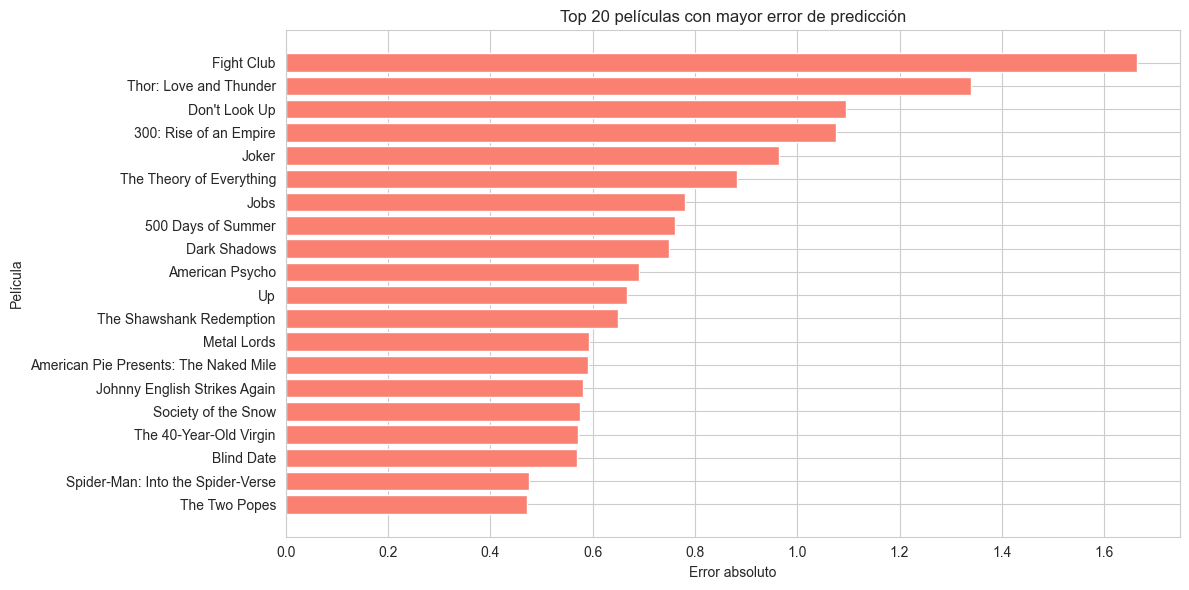

In [20]:
top_errors = val_results.sort_values(by='error', ascending=False).head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_errors['title'], top_errors['error'], color='salmon')
plt.xlabel("Error absoluto")
plt.ylabel("Película")
plt.title("Top 20 películas con mayor error de predicción")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

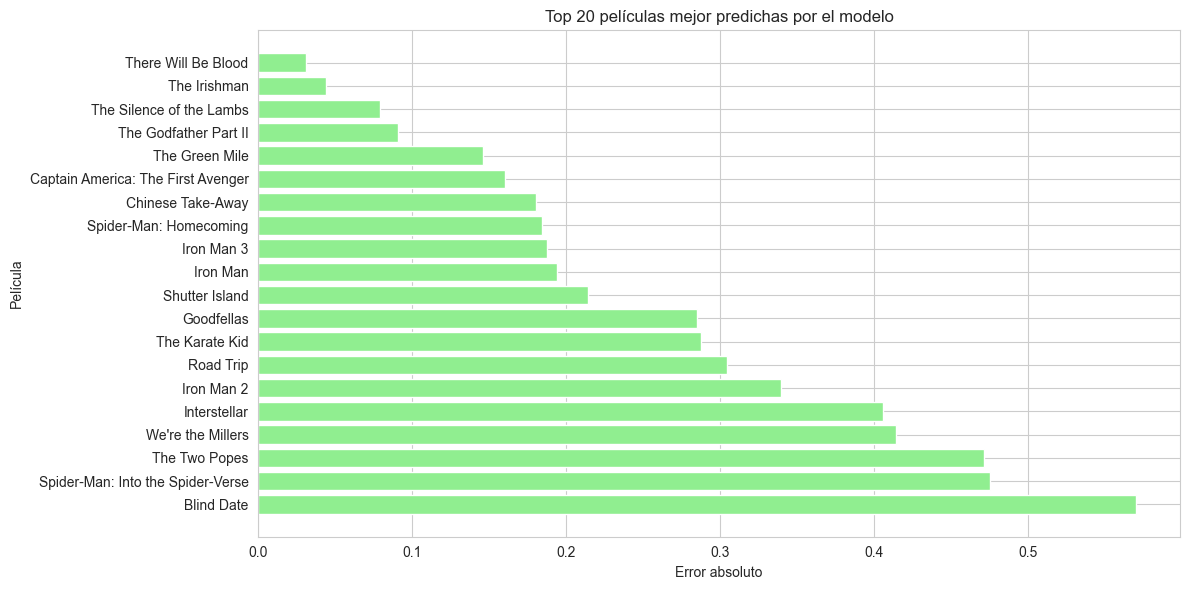

In [21]:
best_predictions = val_results.sort_values(by='error').head(20)

plt.figure(figsize=(12, 6))
plt.barh(best_predictions['title'], best_predictions['error'], color='lightgreen')
plt.xlabel("Error absoluto")
plt.ylabel("Película")
plt.title("Top 20 películas mejor predichas por el modelo")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

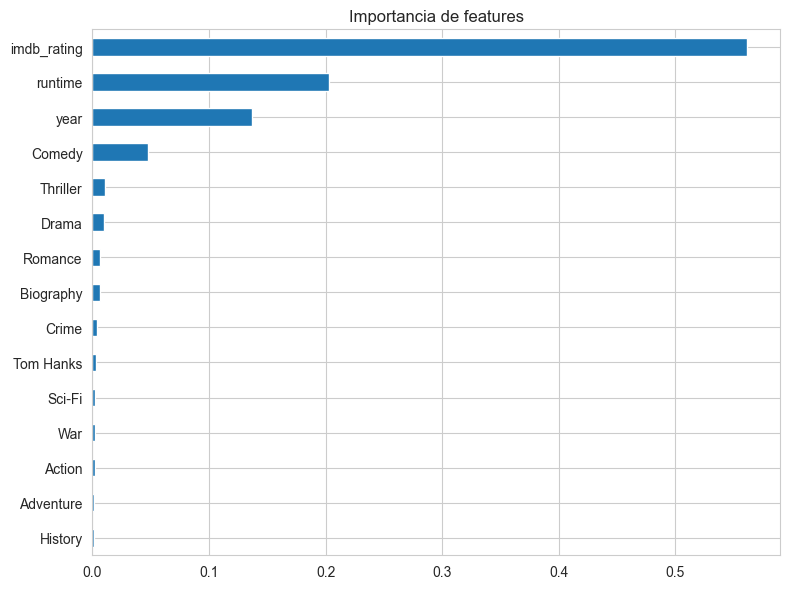

In [22]:
importances = model.feature_importances_

# Si sabés el orden de tus features
feature_names = list(mlb_genres.classes_) + \
                list(mlb_directors.classes_) + \
                list(mlb_actors.classes_) + \
                ['year', 'imdb_rating', 'runtime']

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de features', figsize=(8,6))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Exportación de datos

In [23]:
# Acorta los datos para que no aparezcan tantos actores en el .xlsx
export = recommendations.copy()
export['actors'] = export['actors'].apply(lambda x: x[:3])

export.to_excel('letterboxd_recomendaciones.xlsx', index=False)